# **Twitter Sentiment Classifier** 👍👎
using **Bidirectional Stacked Recurrent Neural Network** with **GRU & LSTM** cells and the **GloVe** pre-trained word embeddings. 

Let's import some essential libraries.

In [1]:
import numpy as np
import pandas as pd
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
import string
import re
from textblob import TextBlob
import torchtext
from torchtext import data
from torchtext.vocab import Vectors, GloVe
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Load the dataset** 🗂

We have to mount (connect) Google Drive where I keep the dataset.

Then, we can import the data in csv format using the pandas `read_csv` method.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/SentimentTweets.csv'
data_csv = pd.read_csv(DATA_PATH)
data_csv = data_csv.dropna()
data_csv.head()

Mounted at /content/drive


,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


## **Data pre-processing** 💽

In [3]:
# Convert the data (from csv type) into dataframe data structure
df = pd.DataFrame(data=data_csv) 
df.head(10)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...
5,725609,0,2262367427,Sat Jun 20 22:22:34 PDT 2009,NO_QUERY,farmtrain,Woot truck fixed!!! Now workin http://myloc.m...
6,1361765,4,2049183514,Fri Jun 05 16:26:26 PDT 2009,NO_QUERY,tinadallasfla,@BLAQSHEEPCEO yea I melt at that lol
7,114606,0,1826379900,Sun May 17 08:22:16 PDT 2009,NO_QUERY,Isoebelle,wants to do something radical...but not sure w...
8,620064,0,2228196366,Thu Jun 18 14:08:18 PDT 2009,NO_QUERY,alox,"@brlamb scratch that, @bgilgoff tweeted it. Ch..."
9,564150,0,2206118765,Wed Jun 17 06:02:05 PDT 2009,NO_QUERY,asimpleparadox,I am sore everywhere. Also found out an assess...


As we can see from above, the target column has 0s and 4s denoting the negative and the positive class respectively. We are going to change the *4s into 1s* using the `replace` method and hence we have:

0 $\rightarrow$ negative tweet 👎

1 $\rightarrow$ positive tweet 👍

In [4]:
df['target'] = df['target'].replace(4,1)
df.head(10)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,1,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,1,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,1,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...
5,725609,0,2262367427,Sat Jun 20 22:22:34 PDT 2009,NO_QUERY,farmtrain,Woot truck fixed!!! Now workin http://myloc.m...
6,1361765,1,2049183514,Fri Jun 05 16:26:26 PDT 2009,NO_QUERY,tinadallasfla,@BLAQSHEEPCEO yea I melt at that lol
7,114606,0,1826379900,Sun May 17 08:22:16 PDT 2009,NO_QUERY,Isoebelle,wants to do something radical...but not sure w...
8,620064,0,2228196366,Thu Jun 18 14:08:18 PDT 2009,NO_QUERY,alox,"@brlamb scratch that, @bgilgoff tweeted it. Ch..."
9,564150,0,2206118765,Wed Jun 17 06:02:05 PDT 2009,NO_QUERY,asimpleparadox,I am sore everywhere. Also found out an assess...


### **Data cleaning** 🧹

In the following code snippets we "clean" the data by doing the following:

* **Drop the uneseccary columns** such as "Unnamed: 0", "id", etc
* **Lower** the characers using the string method `lower` 
* **Remove special characters** such as punctuation points, links, weird characters, etc.

In [5]:
# Drop the unnecessary columns
df.drop(columns = ['Unnamed: 0', 'id', 'date', 'flag', 'user'], inplace = True)
df.head()

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


In [6]:
# Apply text cleaning (lower, remove special chars)
def text_cleaning(text):
  text = text.lower()
  # Remove non alphanumeric characters
  text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  # Remove links
  text = re.sub(r'https?:/\/\S+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  return text

df['text']=df['text'].apply(text_cleaning)
df.head(10)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...
5,0,woot truck fixed now workin http myloc me 4nif
6,1,blaqsheepceo yea i melt at that lol
7,0,wants to do something radical but not sure wha...
8,0,brlamb scratch that bgilgoff tweeted it chann...
9,0,i am sore everywhere also found out an assessm...


### **Tokenization and Lemmatization** 🔑

**Tokenization** is necessary to prepare the data in order to vectorize them using the GloVe pre-trained word embeddings.  
The goal of **Lemmatization** (or Stemming) is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.  
For instance, Lemmatization (or Stemming) will do the following:   
am, are, is $\Rightarrow$ be  
car, cars, car's, cars' $\Rightarrow$ car

In [7]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function that lemmatizes the tokenized text
# text is being tokenized and passed immediately into the lemmatizer 
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(text)])

df['text'] = df.text.apply(lemmatize_text).copy()

df.head(10)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,complete race 4 life in 58mins with girlies fr...
5,0,woot truck fix now workin http myloc me 4nif
6,1,blaqsheepceo yea i melt at that lol
7,0,want to do something radical but not sure what...
8,0,brlamb scratch that bgilgoff tweet it channel ...
9,0,i be sore everywhere also find out an assessme...


### **Split the dataset** 🖇
into *training, validation* and *testing* sets.  
Also, save the datasets in *csv* format in order to be obtained by the TabularDataset later.

In [8]:
from sklearn.model_selection import train_test_split

# Swap the columns in order to be ['text', 'target'] for convenience
df = df.reindex(columns=['text', 'target'])

train, test = train_test_split(df, test_size=0.1, random_state=123)
train, val = train_test_split(train, test_size=0.1, random_state=123)

train.to_csv("/content/drive/My Drive/train.csv", index=False)
test.to_csv("/content/drive/My Drive/test.csv", index=False)
val.to_csv("/content/drive/My Drive/valid.csv", index=False)

In [9]:
print(train.shape)
print(val.shape)
print(test.shape)

(1036800, 2)
(115200, 2)
(128000, 2)


### **Field objects definition 🏞️**
Define the Field object that will store information about the way of preprocessing our data. 
* *Field* is used to specify how to preprocess each data column in our dataset.
* *LabelField* is used only to define the label in classification tasks.

We'll be using ***packed padded sequences***, which will make our RNN *only process the non-padded elements of our sequence*, and for any padded element the output will be a zero tensor. 

Parameters of *Field* object:
* `tokenize = "spacy"` to use the SpaCy tokenizer.
* `include_lengths = True` to tell the RNN how long the sequences (tweets) are in order to use *packed padded sequences*. This will cause `batch.text` to now be a tuple with the first element being our tweet as a numericalized tensor thas has been padded and the second element being the actual length of our sentence.

In [10]:
from torchtext.legacy import data
import spacy

TEXT = data.Field(tokenize = "spacy",
                  include_lengths = True)

LABEL = data.LabelField(dtype=torch.float)

Now we will connect the Field objects we created with the columns in the dataset. In our dataset we don't have a specific title for the columns, so we can just call them "text" and "labels" (note that the order of the fields names is supposed to be in the same order as the in dataset).   
So, we will have: `fields = [('text', TEXT), ('label', LABEL)]`

Then, we can use it to import the data by TabularDataset. TabularDataset is a TorchText data structure that specifically deals with tabular datasets like CSV and TSV. We will need to define the data folder path, the names of the files and the format of the data file (CSV/TSV). 
In the `fields` variable we will define the Fields objects that we just mentioned above. 
`skip_header = True` because we want to skip the first row in the dataset (first row in our dataset is the header: 'text', 'label')

In [11]:
# Use TabularDataset
# loading train, test and validation data 
train_data, valid_data, test_data = data.TabularDataset.splits(
    path = "/content/drive/My Drive/", 
    train = "train.csv", 
    validation = "valid.csv", 
    test = "test.csv",
    format = "csv", 
    skip_header = True, 
    fields = [('text', TEXT), ('label', LABEL)]
)

TabularDataset wraps all the columns (text and labels) into a single object which looks like that:

In [12]:
print(vars(train_data[0]))

{'text': ['i', 'want', 'a', 'walk', 'to', 'remember', 'on', 'dvd'], 'label': '0'}


We can print just the sentence or the label of the first row using our Field object name (in our case we called it 'text' and 'label')

In [13]:
print(train_data[0].text)
print(train_data[0].label)

['i', 'want', 'a', 'walk', 'to', 'remember', 'on', 'dvd']
0


In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1036800
Number of validation examples: 115200
Number of testing examples: 128000


### **Build the GloVe vocabulary** 📖

We will create the vocabulary by mapping all the unique words (in our case we set it to 25000 by `max_size` parameter) in the train_data to an index. Then, we use word embedding that will map the index to the corresponding GloVe word embedding.


In [15]:
# Download the GloVe twitter embeddings
!wget -nc https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -n -q glove.twitter.27B.zip

--2021-10-01 13:42:16--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-10-01 13:42:17--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.09MB/s    in 4m 47s  

2021-10-01 13:47:04 (5.05 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



By default, TorchText will initialize words in our vocabulary but not in our pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting `unk_init = torch.Tensor.normal_`. This will now initialize those words via a Gaussian distribution.

In [16]:
# Load the glove.twitter.27B.50d pre-trained embeddings and build the vocabulary
GloVe_path = '/content/glove.twitter.27B.50d.txt'
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors=torchtext.vocab.Vectors(GloVe_path), 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

100%|█████████▉| 1193513/1193514 [00:39<00:00, 30252.39it/s]


Mind that we 'll have 2 words more than the length of our unique-words-vocabulary. That is because TorchText adds to the vocabulary \<pad> and \<unk> tokens as well. 

We can see below that token `<unk>` has index of 0 in the vocabulary, the token `<pad>` has index of 1, the token `hello` has index of ..., etc. So, if a word is not in the vocabulary we built with the Torchtext using the GloVe model, then this word will be marked as `<unk>` which means unknown.

In [17]:
print(TEXT.vocab['<unk>']) 
print(TEXT.vocab['<pad>'])
print(TEXT.vocab['hello'])
print(TEXT.vocab['world'])

0
1
468
313


In [18]:
# Print the 10 most frequent tokens in our vocabulary
print(TEXT.vocab.freqs.most_common(5))

[('i', 658596), ('be', 422529), ('to', 367057), ('the', 340479), ('a', 249683)]


In [19]:
# Notice the two extra words mentioned above (<unk> and <pad>)
# Uniqe tokens in TEXT vocabulary: MAX_VOCAB_SIZE + 2
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


### **Create the datasets iterators 🔃**

TorchText provides BucketIterator that groups sequences together. It returns a Batch object that contains the data of one batch while the text and labels can be accessed via their column names. Another thing for *packed padded sequences* is that all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting `sort_within_batch = True`.

Parameters:

* `batch_size` is set to the number of examples we want for each batch
* `sort_within_batch = True` in order to sort all tensors in each batch by the `sort_key` mentioned below.
* `sort_key = lambda x: len(x.text)` in order to sort the samples by their lengths.
* `device = device` to use the available device (gpu/cpu)

In [20]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    sort_within_batch = True,
    sort_key = lambda x: len(x.text,),
    device = device)

## **Bidirectional stacked Recurrent Neural Network 🧠**

### **Building the network** 🔨

**Techniques explained (in short):**

**Dropout:** During training, randomly zeroes some of the elements of the input tensor with probability _p_ using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

**Gradient Clipping**: Gradient clipping involves forcing the gradient values (element-wise) to a specific minimum or maximum value if the gradient exceeded an expected range.


**Implementation notes:**

- In this model we are not going to learn the embedding for the `<pad>` token. That is because we want to explicitly tell our model that *padding tokens are irrelevant to determining the sentiment of a sentence*. This means the embedding for the `<pad>` token will remain at what it is initialized to (zero). We do this by passing the index of our `<pad>` token as the `padding_idx` argument to the `nn.Embedding` layer.
- As we are passing the lengths of our sentences to be able to use *packed padded sequences*, we have to add a second argument, `text_lengths`, to forward.
- Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to *only process the non-padded elements* of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the hidden and cell states (both of which are tensors). Without packed padded sequences, hidden and cell are tensors from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. Note that the lengths argument of `packed_padded_sequence` must be a CPU tensor so we explicitly make it one by using `.to('cpu')`.
- We then *unpack the output sequence*, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of output from padding tokens will be zero tensors. Usually, we only have to unpack output if we are going to use it later on in the model. 
- The final hidden state, `hidden`, has a shape of `[num layers * num directions, batch size, hid dim]`. As *we want the final (top) layer forward and backward hidden states*, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

**Adding attention to the model**
> The attention mechanism enables the neural network model to dynamically highlight relevant features of the input data.

In [21]:
# Utility functions for adding attention to the model
# CODE REFERENCE: https://www.kaggle.com/robertke94/pytorch-bi-lstm-attention

import torch.nn.functional as F

NEG_INF = -10000
TINY_FLOAT = 1e-6

# Perform softmax on length dimension with masking
def mask_softmax(matrix, mask=None):
    if mask is None:
        result = F.softmax(matrix, dim=-1)
    else:
        mask_norm = ((1 - mask) * NEG_INF).to(matrix)
        for i in range(matrix.dim() - mask_norm.dim()):
            mask_norm = mask_norm.unsqueeze(1)
        result = F.softmax(matrix + mask_norm, dim=-1)
    return result

# Compute mask average on length dimension
def mask_mean(seq, mask=None):
    if mask is None:
        return torch.mean(seq, dim=1)
    mask_sum = torch.sum(seq * mask.unsqueeze(-1).float(), dim=1) # [b,msl,nc]->[b,nc]
    seq_len = torch.sum(mask, dim=-1) # [b]
    mask_mean = mask_sum / (seq_len.unsqueeze(-1).float() + TINY_FLOAT)

    return mask_mean

# Compute mask max on length dimension
def mask_max(seq, mask=None):
    if mask is None:
        return torch.mean(seq, dim=1)
    torch
    mask_max, _ = torch.max(  # [b,msl,nc]->[b,nc]
        seq + (1 - mask.unsqueeze(-1).float()) * NEG_INF,
        dim=1)
    return mask_max

# Create sequence mask
def seq_mask(seq_len, max_len):
    idx = torch.arange(max_len).to(seq_len).repeat(seq_len.size(0), 1)
    mask = torch.gt(seq_len.unsqueeze(1), idx).to(seq_len)
    return mask

In [22]:
import torch.nn as nn

class BiRNN(nn.Module):
    def __init__(self, cell_type, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, dropout, pad_idx, attention = False):
      
        super(BiRNN, self).__init__()
        
        cells = {
            "RNN"  : nn.RNN, 
            "LSTM" : nn.LSTM,
            "GRU"  : nn.GRU
        }
        
        self.cell_type = cell_type
        self.input_dim = vocab_size 
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention = attention

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # RNN layer
        self.rnn = cells[cell_type](embedding_dim, 
                                    hidden_dim, 
                                    num_layers = n_layers, 
                                    bidirectional = True, 
                                    dropout = dropout)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.out = nn.Linear(hidden_dim * 2, output_dim)
        
        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, output_dim)

        # Sigmoid activation function layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        # embedded = [sent len, batch size, emb dim]
        
        # pack sequence, lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        if self.cell_type == 'LSTM':
          packed_output, (hidden, cell) = self.rnn(packed_embedded)
        else:
          packed_output, hidden = self.rnn(packed_embedded)

        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # unpack sequence -- unnecessary if we don't use output after
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # batch-size first in order to pass it into the attention util functions
        output = output.permute(1,0,2)

        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # hidden = [batch size, hid dim * num directions]
        if self.attention == True:
          max_seq_len = torch.max(output_lengths)
          mask = seq_mask(output_lengths, max_seq_len)
          output = self.attention(output).squeeze(-1)
          output = mask_softmax(output, mask)
          output = torch.sum(output.unsqueeze(-1) * output, dim=1)
          return self.sigmoid(self.out(self.dropout(output)))
        else:
          return self.sigmoid(self.out(self.dropout(hidden)))

In [31]:
# Hyperparameters
CELL_TYPE = 'LSTM'
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 200
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
ATTENTION = True

model = BiRNN(CELL_TYPE, 
              INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              DROPOUT, 
              PAD_IDX,
              ATTENTION)

We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim].

We then replace the initial weights of the embedding layer with the GloVe pre-trained embeddings.

As our `<unk>` and `<pad>` tokens aren't in the pre-trained vocabulary they have been initialized using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to *initialize them both to all zeros* to explicitly tell our model that, *initially*, they are irrelevant for determining sentiment. 
We do this by manually setting their row in the embedding weights matrix to zeros. We get their row by finding the index of the tokens, which we have already done for the padding index.

In [32]:
pretrained_embeddings = TEXT.vocab.vectors
print(f'Pretrained embeddings shape: {pretrained_embeddings.shape}\n')

# replace the initial weights of the embedding layer with the GloVe pre-trained embeddings.
model.embedding.weight.data.copy_(pretrained_embeddings)

# find the index of <unk> token in our vocabulary
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# initialize the <unk> and <pad> tokens to zero
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print('Embedding weights matrix:')
print(model.embedding.weight.data)

Pretrained embeddings shape: torch.Size([25002, 50])

Embedding weights matrix:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0431,  0.5039,  0.2709,  ..., -0.2238, -0.6603, -0.7065],
        ...,
        [-0.7294,  0.3905,  0.2119,  ...,  0.2466, -1.3200, -0.1017],
        [-0.5691,  0.1716, -0.1829,  ..., -0.3321,  0.0159,  0.8214],
        [-0.0542, -0.7096, -0.7794,  ...,  0.4766,  0.0831,  0.6808]])


We can see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the `<pad>` token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however *the `<unk>` token embedding will be learned*.

**Note:** I do not specify the value for the **learning rate**, as the Adam optimizer adjusts the learning rate for each parameter by giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates.

In [33]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
model = model.to(device)
criterion = criterion.to(device)

In [34]:
def calculate_accuracy(predictions, true_labels):
    """
    Returns accuracy per batch in decimal form. 
    i.e., if we get 9/10 right will return 0.9. 
    """
    # Round predictions to the closest integer
    rounded_predictions = torch.round(predictions)
    # Convert into float for division 
    correct = (rounded_predictions == true_labels).float() 
    acc = correct.sum() / len(correct)
    return acc

### **Training** 🏋️‍♂️

For `N_EPOCHS` train the model on the *training dataset* and then evaluate on the *validation dataset*.

Notice that as we have set `include_lengths = True`, our `batch.text` is now a tuple with the first element being the numericalized tensor and the second element being the actual length of each sequence. We separate these into their own variables, `text` and `text_lengths`, before passing them to the model.

In [35]:
# Trains the model on the training dataset using the optimizer and the loss 
# function given by as parameters
def train(model, iterator, optimizer, criterion, clip_value = 5):
    
    epoch_loss = 0
    epoch_acc = 0
    counter = 0

    model.train()
    
    for batch in iterator:
        counter += 1

        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = calculate_accuracy(predictions, batch.label)
        
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / counter, epoch_acc / counter

In [36]:
# Evaluates the model on the validation dataset
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    counter = 0

    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            counter += 1
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = calculate_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / counter, epoch_acc / counter

In [37]:
# A function for measuring the time between epochs
import time

def epoch_time(start_time, end_time):
    """
    Returns time elapsed for an epoch, 
    i.e. 1, 23 which means 1 minute and 23 seconds.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
# For N_EPOCHS train the model and test on the validation set

N_EPOCHS = 10
CLIP_VALUE = 5

total_train_loss = []
total_train_acc = []
total_valid_loss = []
total_valid_acc = []

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, CLIP_VALUE)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    total_valid_loss.append(valid_loss)
    total_valid_acc.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 49s
	Train Loss: 0.453 | Train Acc: 78.51%
	 Val. Loss: 0.399 |  Val. Acc: 81.99%
Epoch: 02 | Epoch Time: 3m 49s
	Train Loss: 0.405 | Train Acc: 81.52%
	 Val. Loss: 0.382 |  Val. Acc: 82.74%
Epoch: 03 | Epoch Time: 3m 49s
	Train Loss: 0.389 | Train Acc: 82.43%
	 Val. Loss: 0.374 |  Val. Acc: 83.16%
Epoch: 04 | Epoch Time: 3m 48s
	Train Loss: 0.380 | Train Acc: 82.90%
	 Val. Loss: 0.371 |  Val. Acc: 83.53%
Epoch: 05 | Epoch Time: 3m 49s
	Train Loss: 0.373 | Train Acc: 83.32%
	 Val. Loss: 0.368 |  Val. Acc: 83.59%
Epoch: 06 | Epoch Time: 3m 48s
	Train Loss: 0.368 | Train Acc: 83.59%
	 Val. Loss: 0.367 |  Val. Acc: 83.69%
Epoch: 07 | Epoch Time: 3m 49s
	Train Loss: 0.363 | Train Acc: 83.83%
	 Val. Loss: 0.365 |  Val. Acc: 83.68%
Epoch: 08 | Epoch Time: 3m 48s
	Train Loss: 0.359 | Train Acc: 84.03%
	 Val. Loss: 0.366 |  Val. Acc: 83.74%
Epoch: 09 | Epoch Time: 3m 48s
	Train Loss: 0.356 | Train Acc: 84.21%
	 Val. Loss: 0.365 |  Val. Acc: 83.86%
Epoch: 10 | Epoch T

### **Testing ✅**

Testing (evaluating) the model on the *test dataset*.

In [39]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.366 | Test Acc: 83.73%


### **Metrics** 📈

In [40]:
def get_predictions(model, iterator):
  """
  A function for getting the predictions for each tweet along with the true label
  in order to have them in a list form for the classification report, ROC curve, etc.
  Returns a list of predictions and a list of the corresponding true label values.
  i.e., returns [prediction1, prediction2, .., predictionN], 
  [TrueLabel1, TrueLabel2, .., TrueLabelN]
  """
  test_predictions = []
  test_labels = []

  model.eval()
  with torch.no_grad():
      for batch in iterator:
          text, lengths = batch.text
          true_label = batch.label.reshape(-1, 1)
          prediction = model(text, lengths)

          test_predictions.append(prediction)
          test_labels.append(true_label)
  
  test_predictions = torch.cat(test_predictions, dim=0).cpu()
  test_labels = torch.cat(test_labels, dim=0).cpu()

  return test_predictions, test_labels

In [41]:
# For the test dataset, get our predictions and the corresponding true labels
test_predictions, test_labels = get_predictions(model, test_iterator)

**Classification Report**

A Classification report is used to measure the quality of predictions from our  classification model.  
More specifically, it gives us the **precision**, **recall** and **F1-score**.

In [42]:
from sklearn.metrics import classification_report

test_predictions = test_predictions.ge(.5).view(-1).cpu()
test_labels = test_labels.cpu()

print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84     63835
         1.0       0.83      0.84      0.84     64165

    accuracy                           0.84    128000
   macro avg       0.84      0.84      0.84    128000
weighted avg       0.84      0.84      0.84    128000



**Graphs**

Plotting the **loss per epoch** and **accuracy per epoch** on the training and the validation datasets.

In [43]:
plt.style.use('seaborn-whitegrid') # plot style

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

  ax1.plot(range(epochs), train_loss, 'bo-', label = 'Training loss')
  ax1.plot(range(epochs), val_loss , 'ro-', label = 'Validation loss')
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Loss/Epoch', y = 1.03, fontsize = 15)
  ax1.set_xlim([-1,epochs])
  ax1.legend(loc="best")

  ax2.plot(range(epochs), train_acc, 'bo-', label = 'Training accuracy')
  ax2.plot(range(epochs), val_acc , 'ro-', label = 'Validation accuracy')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Accuracy/Epoch', y = 1.03, fontsize = 15)
  ax2.set_xlim([-1,epochs])
  ax2.legend(loc="best")

  plt.show()

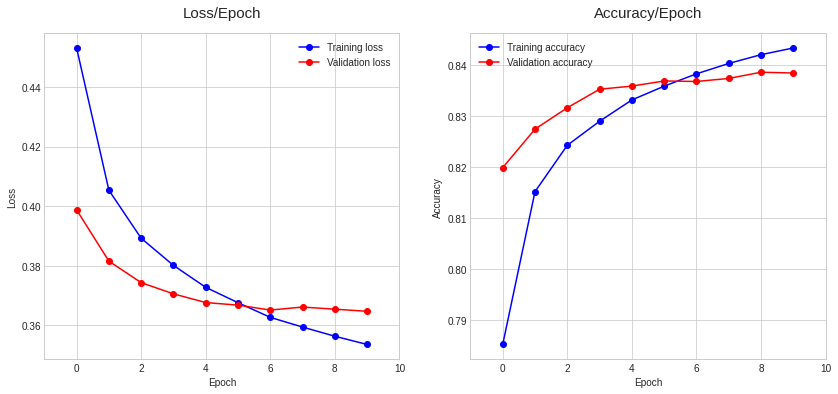

In [44]:
plot_loss_accuracy(total_train_loss, total_train_acc, total_valid_loss, total_valid_acc, N_EPOCHS)

**ROC curve**

The ROC curve shows the trade-off between `True Positive Rate` and `1 – False Positive Rate`. Classifiers that give curves closer to the top-left corner indicate a better performance. AUC stands for "Area Under the ROC Curve" and with value of 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.  
We can see that our classifier is in the range of 0.8 to 0.9 which is considered *excellent* 😀

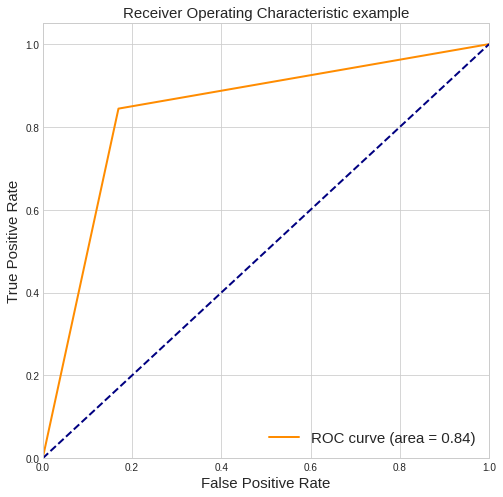

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert tensors to numpy arrays after we pass them to cpu
test_predictions = test_predictions.cpu().detach().numpy()
test_labels = test_labels.cpu().detach().numpy()

# Label binarization and store num of classes
test_labels = label_binarize(test_labels, classes=[0, 1])
n_classes = test_labels.shape[1]

# Calculate false positive rate (fpr) and true positive rate (tpr)
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_labels[:], test_predictions[:])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic example', fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()

**Confusion matrix**

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. In other words, *the confusion matrix shows the ways in which our classification model is confused when it makes predictions.*




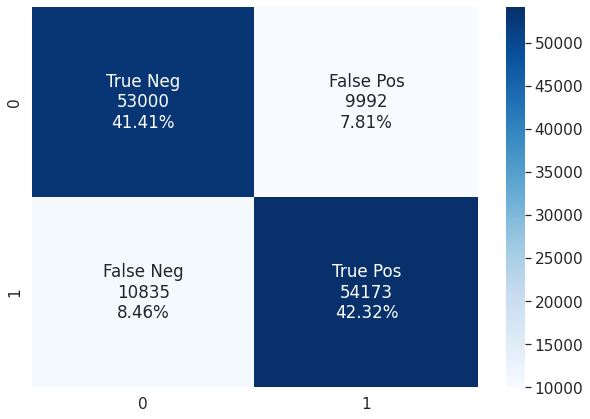

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

df_cf_matrix = pd.DataFrame(confusion_matrix(test_predictions, test_labels.round()))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)

group_labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in df_cf_matrix.values.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in df_cf_matrix.values.flatten()/np.sum(df_cf_matrix.values.flatten())]

box_labels = [f"{v1}\n{v2}\n{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(df_cf_matrix.shape[0],df_cf_matrix.shape[1])

sn.heatmap(df_cf_matrix, annot=box_labels, fmt='', cmap='Blues')

## **Summary** (some numbers) 📊

I have built a Bidirectional Stacked Reccurrent Neural Network model with LSTM & GRU cells, which uses the GloVe pre-trained word embeddings for vectorizing the data (i.e., convert the words into numbers). 

My best model got accuracy of ***84%*** and was having the following properties:

- Batch-size = $2^{7}$ = 128
- Cell type: LSTM
- Number of epochs = 10
- GloVe twitter word embeddings of *50 dimensions*
- A hidden layer of size 200 
- A *dropout* probability of 50%
- *Gradient clipping* value of 5
- Sigmoid function at the output

**Note:** Having experimented with different models by changing the hyperparameters, I must mention that *whether we use GRU or LSTM, the accuracy is almost the same*, and as GRU cells are simpler and faster, we can prefer them, as the difference in accuracy is negligible in this case. In addition, after testing my model with and without attention, I notice that *using attention we get slightly better accuracy of the model*. Finally, we can *(early) stop* training after 5 epochs as the model only slightly increases its accuracy after that time. I use 10 epochs in order to have sufficient data for the graphs.

**Comments:** We can see that RNNs are much better than FFNNs, as in our [FFNN with GloVe](https://colab.research.google.com/drive/1PbAQPiyTpwWAeKV5LC9bNCERwPZn1qC3?usp=sharing) we had *70% accuracy in 70 epochs* and now we have (again using GloVe) *84% accuracy in just 10 epochs*! Also, in [FFNN with TF-IDF](https://colab.research.google.com/drive/12Yh2X91JOkYBEG3yXfcBRjORjHh1KTPy?usp=sharing), we had *80% accuracy but again in 70 epochs* and now our accuracy is *84% in just 10 epochs* which is obviously better.